In [ ]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# Modelling Imports
import sklearn
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

# Useful relative paths
data_directory = './data/NELA'
model_directory ='./models'

## 1 – Modelling with LSTM!

In [46]:
X = pd.read_csv('{}/complete_processed.csv'.format(data_directory))
y = X['label']
X.drop('label',axis=1)
;

''

In [5]:
full_processed_split=X['full_preprocessed'].apply(lambda x: x.split())
w2v_model = gensim.models.Word2Vec(sentences=full_processed_split, size=100, window=5, min_count=1)

In [6]:
len(w2v_model.wv.vocab)

577043

In [17]:
w2v_model.wv.most_similar("trump")

[('trumpthe', 0.7715708613395691),
 ('obama', 0.7268573045730591),
 ('trumpand', 0.6810164451599121),
 ('trumpwe', 0.6529550552368164),
 ('obamas', 0.6447025537490845),
 ('president', 0.6334847211837769),
 ('trumpi', 0.6319250464439392),
 ('announcementunlike', 0.6286493539810181),
 ('trumpit', 0.6255168914794922),
 ('rumsfeldin', 0.6162499785423279)]

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_processed_split)
X_lstm = tokenizer.texts_to_sequences(full_processed_split)

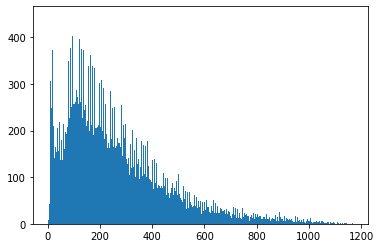

In [24]:
plt.hist([len(x) for x in X_lstm], bins=500)
plt.show() 

In [26]:
nos = np.array([len(x) for x in X_lstm])
len(nos[nos  < 700])

42044

In [27]:
maxlen = 700 

X_lstm = pad_sequences(X_lstm, maxlen=maxlen)

In [28]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [29]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [31]:
vocab_size = len(word_index) + 1
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          57704400  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 57,821,777
Trainable params: 117,377
Non-trainable params: 57,704,400
_________________________________________________________________


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y) 

In [34]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
721/721 [==============================] - 448s 622ms/step - loss: 0.4716 - acc: 0.7637 - val_loss: 0.4657 - val_acc: 0.7536
Epoch 2/6
721/721 [==============================] - 581s 805ms/step - loss: 0.4056 - acc: 0.8051 - val_loss: 0.4212 - val_acc: 0.7863
Epoch 3/6
721/721 [==============================] - 507s 703ms/step - loss: 0.3728 - acc: 0.8213 - val_loss: 0.3736 - val_acc: 0.8231
Epoch 4/6
721/721 [==============================] - 472s 655ms/step - loss: 0.3354 - acc: 0.8470 - val_loss: 0.3928 - val_acc: 0.8144
Epoch 5/6
721/721 [==============================] - 473s 656ms/step - loss: 0.2951 - acc: 0.8658 - val_loss: 0.3622 - val_acc: 0.8352
Epoch 6/6
721/721 [==============================] - 547s 758ms/step - loss: 0.2424 - acc: 0.8964 - val_loss: 0.3681 - val_acc: 0.8351


In [35]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5604
           1       0.82      0.84      0.83      5374

    accuracy                           0.83     10978
   macro avg       0.83      0.83      0.83     10978
weighted avg       0.83      0.83      0.83     10978



In [37]:
model.save('models/LSTM/')

In [40]:
model1 = keras.models.load_model('models/LSTM/')

In [42]:
y_pred = (model1.predict(X_test) >= 0.5).astype("int")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      5604
           1       0.82      0.84      0.83      5374

    accuracy                           0.83     10978
   macro avg       0.83      0.83      0.83     10978
weighted avg       0.83      0.83      0.83     10978

